In [93]:
#  Please select keypoint regression model to evaluate on the test set
MODEL = 'yolov8' # 'hourglass' or 'yolov8'
WEIGHTS_TYPE = 'sy'
DATASET = 'spv2-COCO-s'
DATA_TYPE = 'synthetic'
#Choose PnP method
EPNP = False #True for EPnP, False for ITERATIVE. Consider using EPnP for yolov8 and ITERATIVE for hourglass

# Prepare Notebook

In [94]:
import cv2
import numpy as np
import json
import os
import sys
import pycocotools
__file__ = ""
sys.path.append(os.path.abspath(os.path.join(os.path.dirname(__file__), '..')))

from utils.visualizations import *
from utils.metrics import *
from utils.transformations import *

## CONFIGURATION ###
RELATIVE_ROOT = '..'
ROOT_PATH = os.path.abspath(os.path.join(os.path.dirname(__file__), RELATIVE_ROOT))


COCO_FILE = f'data/{DATASET}/{DATA_TYPE}/annotations/test.json'
COCO_PATH = os.path.join(ROOT_PATH, COCO_FILE)

RESULTS_FILE = f'keypoints_regression/results/{MODEL}/{WEIGHTS_TYPE}_test/{DATA_TYPE}_keypoints_regression.json'
RESULTS_PATH = os.path.join(ROOT_PATH, RESULTS_FILE)

CAMERA_FILE = f'data/{DATASET}/camera.json'
CAMERA_PATH = os.path.join(ROOT_PATH, CAMERA_FILE)

KEYPOINTS_FILE = f'data/{DATASET}/keypoints.json' # 3D keypoints of the model 
KEYPOINTS_PATH = os.path.join(ROOT_PATH, KEYPOINTS_FILE)
kpsz = [640,400]

OUTPUT_DIR = f'pose_estimation/results/{MODEL}/{WEIGHTS_TYPE}_test'
OUTPUT_PATH = os.path.join(ROOT_PATH, OUTPUT_DIR)
os.makedirs(OUTPUT_PATH, exist_ok=True)


# Load annotations

In [95]:
# Load the JSON data
with open(RESULTS_PATH , 'r') as file:
    results = json.load(file)
coco = COCO(COCO_PATH)

loading annotations into memory...
Done (t=0.01s)
creating index...
index created!


# Run Perspective-n-Points

In [96]:
# Load the camera parameters
with open(CAMERA_PATH, 'r') as file:
    camera_data = json.load(file)

camera_matrix = np.array(camera_data['cameraMatrix'], dtype=np.float32)
dist_coeffs = np.array(camera_data['distCoeffs'], dtype=np.float32)

# 3D keypoints of the object
with open(KEYPOINTS_PATH, 'r') as file:
    data_keypoints = json.load(file)

_3D_keypoints = [data['position'] for data in data_keypoints['keypoints']]
_3D_keypoints = np.array(_3D_keypoints, dtype=np.float32).reshape(-1, 1, 3).squeeze()

# filename list to store the filename names
img_list = []
# Lists to store the rotation and translation vectors
gt_tra_list = []
gt_quat_list = []
p_tra_list = []
p_quat_list = []

# PnP method
PnP_flag = cv2.SOLVEPNP_EPNP if EPNP else cv2.SOLVEPNP_ITERATIVE
solver = 'EPnP' if EPNP else 'ITERATIVE'

for entry in results:
    # Load and process keypoints for the filename
    annotation = loadImgAnns(entry['filename'], coco)
    if not annotation:
        print(f'No annotation found for filename {entry["filename"]}')
        continue
    if entry['n_sat'] ==1 and len(entry['p_keypoints']) == len(entry['gt_keypoints']):
        gt_keypoints = scaleCoord(entry['gt_keypoints'],input_size=kpsz,target_size=[640,400]) # Scale to match camera matrix
        gt_keypoints = np.array(gt_keypoints, dtype=np.float32).squeeze().reshape(-1, 1, 2)
    
        p_keypoints = scaleCoord(entry['p_keypoints'],input_size=kpsz,target_size=[640,400])
        p_keypoints = np.array(p_keypoints, dtype=np.float32).squeeze().reshape(-1, 1, 2)

        p_success, p_rotation_vector, p_translation_vector,outliers = cv2.solvePnPRansac(
            _3D_keypoints,
            p_keypoints,
            camera_matrix,
            dist_coeffs,
            flags=PnP_flag,
            iterationsCount=1000,
            confidence=0.9,
            
            
        )
        
        img_list.append(entry['filename'])
        gt_quat_list.append(np.array(annotation['pose_quaternion']))
        gt_tra_list.append(np.array(annotation['pose_translation']))
        
        
        if p_success and np.linalg.norm(p_translation_vector) < 1e1: # Put a threshold on the translation vector
            p_quat_vector = rotation2Quat(p_rotation_vector)
            p_quat_list.append(p_quat_vector)
            p_tra_list.append(p_translation_vector.squeeze())
        else:
            print(f'No solution found for filename {entry["filename"]}')
            p_quat_list.append(np.array([1,0,0,0]))
            p_tra_list.append(np.array([0,0,0]))


No solution found for filename img017537.jpg
No solution found for filename img034037.jpg
No solution found for filename img017492.jpg
No solution found for filename img009584.jpg
No solution found for filename img000201.jpg
No solution found for filename img033801.jpg
No solution found for filename img051259.jpg
No solution found for filename img000315.jpg
No solution found for filename img022949.jpg
No solution found for filename img034479.jpg
No solution found for filename img042155.jpg
No solution found for filename img038760.jpg
No solution found for filename img012798.jpg
No solution found for filename img034915.jpg
No solution found for filename img022661.jpg
No solution found for filename img056172.jpg
No solution found for filename img045869.jpg
No solution found for filename img009049.jpg
No solution found for filename img036703.jpg
No solution found for filename img022916.jpg
No solution found for filename img043094.jpg
No solution found for filename img048513.jpg
No solutio

# View & Export results

------- Pose Estimation Scores -------
Average predicted position score [m]: 0.048106330096081944
Standard deviation of predicted position score [m]: 0.12924667053287295
Average predicted orientation score [rad]: 0.07117271591211287
Standard deviation of predicted orientation score [rad]: 0.36370720625162767
------- Total Score -------
Total score for predicted poses: 0.11927904600819482
------------------------------------


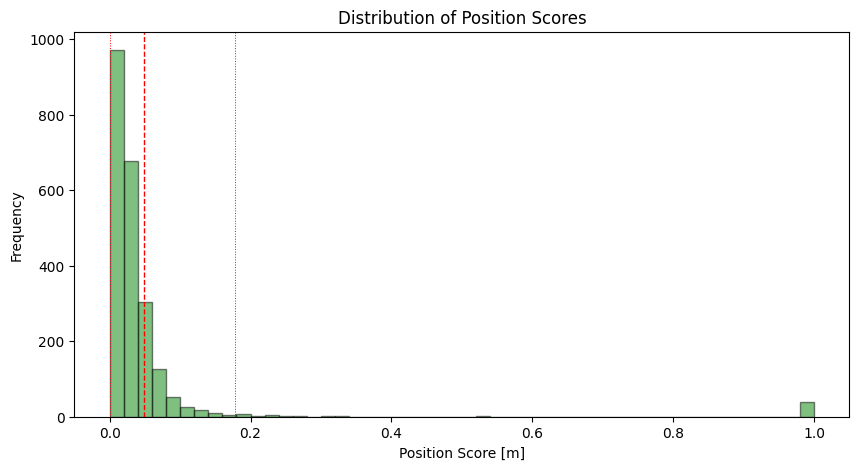

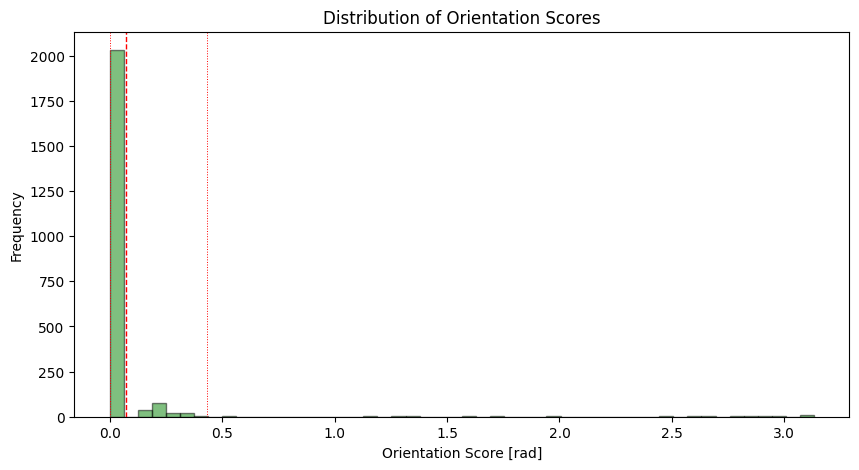

Evaluation results saved successfully.


In [97]:
# Visualize the predicted keypoints results
poseMetrics = PoseMetrics(img_list,p_tra_list, p_quat_list, gt_tra_list, gt_quat_list)
poseMetrics.save(save_dir=OUTPUT_PATH,data_type=DATA_TYPE,solver_type=(solver+'_RANSAC'))